In [1]:
import io
import requests
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, Dinov2Model

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Download a sample image and force 448x448
url = "https://cdn.pixabay.com/photo/2017/09/09/16/38/vegetables-2732589_1280.jpg"
img = Image.open(io.BytesIO(requests.get(url, timeout=10).content)).convert("RGB")


In [2]:
# 2) DINOv2 ViT-S/14 features (tokens at 32x32 for 448 with patch 14)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True, token=False)
model = Dinov2Model.from_pretrained("facebook/dinov2-base", token=False).to(device).eval()


In [3]:
# 3) Preprocess the image: resize + center crop + normalize

img_size = 448

inputs = processor(
    images=img,
    do_resize=True,
    size={"shortest_edge": img_size},
    do_center_crop=True,
    crop_size={"height": img_size, "width": img_size},
    return_tensors="pt",
)
hr_image = inputs["pixel_values"].to(device)  # (1, 3, 448, 448), ImageNet-normalized


In [4]:
# 4) Forward pass to get features
with torch.no_grad():
    out = model(pixel_values=hr_image)
    tokens = out.last_hidden_state[:, 1:, :]  # drop [CLS]

# 5) Reshape tokens to feature map
B, N, C = tokens.shape
h = w = int(N ** 0.5)
assert h * w == N, f"Non-square token grid (N={N})"
lr_features = tokens.reshape(B, h, w, C).permute(0, 3, 1, 2).contiguous()  # (1, C, 32, 32)

In [5]:
# 6) Load AnyUp from torch.hub and upsample to 448x448
#    (hr_image must be ImageNet-normalized; lr_features can be from any encoder)
upsampler = torch.hub.load("wimmerth/anyup", "anyup", verbose=False).to(device).eval()
with torch.no_grad():
    # q_chunk_size can reduce memory if needed
    hr_features = upsampler(hr_image, lr_features, q_chunk_size=256)  # (1, C, 448, 448)

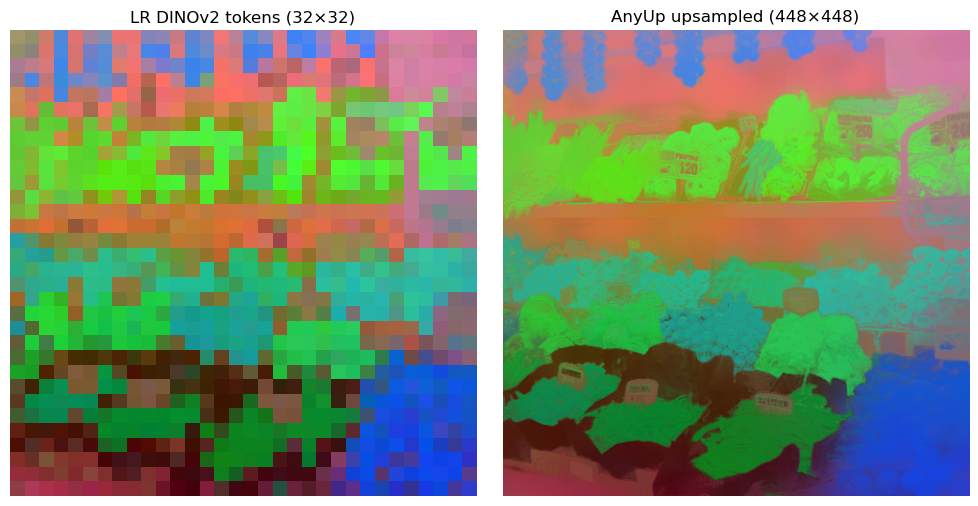

In [6]:
# 4) Joint PCA
with torch.no_grad():
    lr_flat = lr_features[0].permute(1, 2, 0).reshape(-1, C)
    hr_flat = hr_features[0].permute(1, 2, 0).reshape(-1, C)
    all_feats = torch.cat([lr_flat, hr_flat], dim=0)

    mean = all_feats.mean(dim=0, keepdim=True)
    X = all_feats - mean

    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    pcs = Vh[:3].T

    proj_all = X @ pcs

    # Split back and min-max normalize jointly for consistent coloring
    n_lr = h * w
    proj_lr = proj_all[:n_lr].reshape(h, w, 3)
    proj_hr = proj_all[n_lr:].reshape(img_size, img_size, 3)

    cmin = proj_all.min(dim=0).values
    cmax = proj_all.max(dim=0).values
    crng = (cmax - cmin).clamp(min=1e-6)

    lr_rgb = ((proj_lr - cmin) / crng).cpu().numpy()
    hr_rgb = ((proj_hr - cmin) / crng).cpu().numpy()

    # 5) Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(lr_rgb)
    axs[0].set_title(f"LR DINOv2 tokens ({h}×{w})")
    axs[0].axis("off")
    axs[1].imshow(hr_rgb)
    axs[1].set_title(f"AnyUp upsampled ({img_size}×{img_size})")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

# Test with Sat images


In [1]:
import io
import requests
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, Dinov2Model

device = "cuda" if torch.cuda.is_available() else "cpu"

img = Image.open("/home/mak/PycharmProjects/SegEdge/experiments/get_data_from_api/patches_mt/test.tif").convert("RGB")


In [2]:
from transformers import AutoModel

# 2) DINOv3 ViT-L/16 features (tokens at 32x32 for 500 with patch 16)
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m")
model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m", token=False).to(device).eval()



In [3]:

img_size = 300

inputs = processor(
    images=img,
    do_resize=True,
    size={"shortest_edge": img_size},
    do_center_crop=True,
    crop_size={"height": img_size, "width": img_size},
    return_tensors="pt",
)
hr_image = inputs["pixel_values"].to(device)  #

with torch.no_grad():
    out = model(pixel_values=hr_image)
    tokens = out.last_hidden_state[:, 1:, :]  # drop [CLS]

B, N, C = tokens.shape
h = w = int(N ** 0.5)
if not  h * w == N:


    print (f"Non-square token grid (N={N})")
    print("Original tokens shape:", tokens.shape)

    #cut to square
    new_N = h * h
    tokens = tokens[:, :new_N, :]
    print("Cut tokens to:", tokens.shape)





lr_features = tokens.reshape(B, h, w, C).permute(0, 3, 1, 2).contiguous()  # (1, C, 32, 32)


Non-square token grid (N=328)
Original tokens shape: torch.Size([1, 328, 1024])
Cut tokens to: torch.Size([1, 324, 1024])


In [4]:
# 3) Load AnyUp from torch.hub and upsample to 448x448
#    (hr_image must be ImageNet-normalized; lr_features can be from any encoder)
upsampler = torch.hub.load("wimmerth/anyup", "anyup", verbose=False).to(device).eval()
with torch.no_grad():
    # q_chunk_size can reduce memory if needed
    hr_features = upsampler(hr_image, lr_features, q_chunk_size=256)

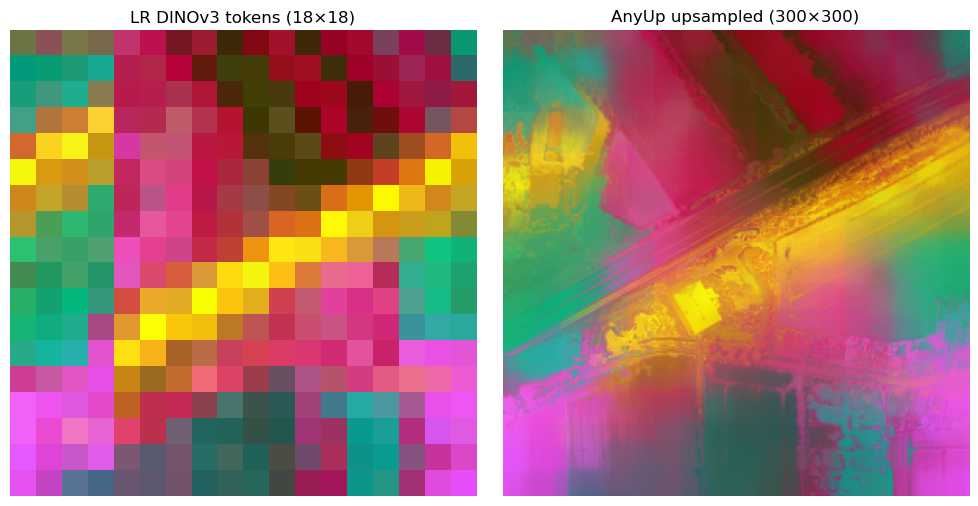

In [5]:

# 4) Joint PCA
with torch.no_grad():
    lr_flat = lr_features[0].permute(1, 2, 0).reshape(-1, C)
    hr_flat = hr_features[0].permute(1, 2, 0).reshape(-1, C)
    all_feats = torch.cat([lr_flat, hr_flat], dim=0)

    mean = all_feats.mean(dim=0, keepdim=True)
    X = all_feats - mean

    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    pcs = Vh[:3].T

    proj_all = X @ pcs

    # Split back and min-max normalize jointly for consistent coloring
    n_lr = h * w
    proj_lr = proj_all[:n_lr].reshape(h, w, 3)
    proj_hr = proj_all[n_lr:].reshape(img_size, img_size, 3)

    cmin = proj_all.min(dim=0).values
    cmax = proj_all.max(dim=0).values
    crng = (cmax - cmin).clamp(min=1e-6)

    lr_rgb = ((proj_lr - cmin) / crng).cpu().numpy()
    hr_rgb = ((proj_hr - cmin) / crng).cpu().numpy()

    # 5) Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(lr_rgb)
    axs[0].set_title(f"LR DINOv3 tokens ({h}×{w})")
    axs[0].axis("off")
    axs[1].imshow(hr_rgb)
    axs[1].set_title(f"AnyUp upsampled ({img_size}×{img_size})")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()